## Randomized Network Learnability 

In [53]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp

import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter
from copy import copy

from tools import learnabilityHelpers as lh

## this suppresses the warnings encountered during normal use of Matthew's Corr Coeff from sklearn
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
go_file = '../data/goData/kinase_go_processes.csv'
go_dir = './'

# create a dictionary with our datasets
go_data_dict, go_transform_dict = lh.get_go_data_dict(go_file=go_file)

Now, we need to get our cluster data and make a few DataFrames with the clusters and go_annotations attached

In [4]:
cluster_dir = '../results/randomizedResults/'

spinglass_file = 'consensus_spinglass.txt'
spinglass_data_dict = {key:lh.add_cluster_labels(cluster_dir+spinglass_file,
                                  val) for key, val in go_data_dict.items()}

fastgreedy_file = 'fastgreedy_clusters.txt'
fastgreedy_data_dict = {key:lh.add_cluster_labels(cluster_dir+fastgreedy_file,
                                  val) for key, val in go_data_dict.items()}

eigen_file = 'consensus_eigenvector.txt'
eigen_data_dict = {key:lh.add_cluster_labels(cluster_dir+eigen_file,
                                  val) for key, val in go_data_dict.items()}

labelprop_file = 'consensus_label_propagation.txt'
labelprop_dict = {key:lh.add_cluster_labels(cluster_dir+labelprop_file,
                                  val) for key, val in go_data_dict.items()}

walktrap_file = 'consensus_walktrap.txt'
walktrap_dict = {key:lh.add_cluster_labels(cluster_dir+walktrap_file,
                                  val) for key, val in go_data_dict.items()}

louvain_super_file = 'louvain_clusters.txt'
louvain_super_dict = {key:lh.add_cluster_labels(cluster_dir+louvain_super_file,
                                  val) for key, val in go_data_dict.items()}

louvain_sub_file = 'louvain_small_clusters.txt'
louvain_sub_dict = {key:lh.add_cluster_labels(cluster_dir+louvain_sub_file,
                                  val) for key, val in go_data_dict.items()}

infomap_file = 'consensus_infomap.txt'
infomap_dict = {key:lh.add_cluster_labels(cluster_dir+infomap_file,
                                  val) for key, val in go_data_dict.items()}

edge_betweenness_file = 'edge_betweenness_community_clusters.txt'
edge_betweenness_dict = {key:lh.add_cluster_labels(cluster_dir+edge_betweenness_file,
                                  val) for key, val in go_data_dict.items()}

method_list = ['spinglass', 'fastgreedy', 'eigen', 'labelprop', 'walktrap', 'louvain_super', 'louvain_sub', 'infomap', 'edge_between']
method_dicts = [spinglass_data_dict, fastgreedy_data_dict, eigen_data_dict, labelprop_dict, walktrap_dict, louvain_super_dict, louvain_sub_dict, infomap_dict, edge_betweenness_dict]
composite_data_dict = {x:y for x,y in zip(method_list, method_dicts)}

Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due

Now, let's import a few linear classifiers

In [5]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear', class_weight='balanced')
cnb = CNB()

classifiers = [svm, cnb]
clf_names = [str(clf.__class__).split('.')[-1][0:-2] for clf in classifiers]

And get the accuracy and MCC scores for our datasets

In [6]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews'], 'parallel':mp.cpu_count()-1, 'test_size':0.3}
results_dict = {}

for method in composite_data_dict.keys():
    results_dict[method] = {str(clf.__class__).split('.')[-1][0:-2]:lh.validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in composite_data_dict[method].items() for clf in classifiers}
    

In [7]:
mean_results = {}
std_results = {}

for method in method_list:
    mean_results[method] = {key:np.mean(np.vstack(map(np.array, results_dict[method][key])), axis=0) for key in results_dict[method].keys()}
    std_results[method] = {key:np.std(np.vstack(map(np.array, results_dict[method][key])), axis=0) for key in results_dict[method].keys()}
    

In [11]:
cluster_descriptions = {}
mod_scores = {}

mod_table = pd.read_csv('../results/randomizedResults/clustering_modularity_results.txt', sep='\t')
mod_scores = {x:y for x,y in zip(method_list, mod_table.loc[0].values)}

for method in method_list:
    # grab the cluster list from one of the datatype dictionaries
    cluster_list = composite_data_dict[method]['go']['cluster']
    
    # create a counter to get the count data
    clust_counter = Counter(cluster_list)
    
    # count and number of cluster data
    cluster_counts = list(clust_counter.values())
    n_clust = len(cluster_counts)
    
    # mean and std of cluster size
    size_mean = np.round(np.mean(cluster_counts), 1)
    size_std = np.round(np.std(cluster_counts), 1)
    
    # largest and smallest cluster size
    size_max = np.max(cluster_counts) 
    
    # update size and modularity data
    cluster_descriptions[method] = {'N_clust':n_clust, 'Mean clust size':size_mean, 'Clust size std.':size_std, 'Largest clust size':size_max}
    cluster_descriptions[method].update({'Modularity':np.round(mod_scores[method],3)})
    
    # update learnability
    # clf-specific results
    #cluster_descriptions[method].update({clf_name+' accuracy':np.round(mean_results[method][clf_name],2)[0] for clf_name in clf_names})
    #cluster_descriptions[method].update({clf_name+' MCC':np.round(mean_results[method][clf_name],2)[1] for clf_name in clf_names})
    # composite results
    cluster_descriptions[method].update({'Composite Accuracy':np.round(np.mean([mean_results[method][clf_name][0] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Comp Acc std.':np.round(np.mean([std_results[method][clf_name][0] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Composite MCC':np.round(np.mean([mean_results[method][clf_name][1] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Comp MCC std.':np.round(np.mean([std_results[method][clf_name][1] for clf_name in clf_names]),2)})
    
results_df = pd.DataFrame.from_dict(cluster_descriptions, orient='index').sort_values(by='Composite MCC', ascending=False)

results_df.columns = ['No. Clusters', 'Mean size', 'sigma size', 'Largest clust',
       'Mod', 'Comp Acc', 'sigma Comp Acc', 'Comp MCC',
       'sigma Comp MCC']

display(results_df)

,No. Clusters,Mean size,sigma size,Largest clust,Mod,Comp Acc,sigma Comp Acc,Comp MCC,sigma Comp MCC
louvain_super,9,57.4,35.8,142,0.368,0.62,0.0,0.56,0.0
labelprop,4,129.2,217.5,506,0.273,0.84,0.0,0.53,0.0
louvain_sub,26,19.9,27.9,123,0.321,0.56,0.0,0.51,0.0
fastgreedy,10,51.7,48.5,126,0.339,0.59,0.0,0.50,0.0
infomap,52,9.9,32.6,236,0.282,0.58,0.0,0.41,0.0
spinglass,85,6.1,15.5,111,0.350,0.39,0.0,0.36,0.0
eigen,6,86.2,54.6,188,0.248,0.48,0.0,0.32,0.0
edge_between,205,2.5,11.3,145,0.171,0.32,0.0,0.17,0.0
walktrap,44,11.8,11.3,42,0.017,0.16,0.0,0.13,0.0


We can see that:

> 1. Leading Eigenvalues does not produce valid clusterings as while accuracy is high, MCC is relatively poor
> 2. Fast Greedy appears to have the best learnability, but we should remeber that Consensus Spinglass has many more classes
> 3. Filtering/TFIDF does not negatively impact the learnability, so we can ignore the rare labels in our analysis


## Convert pandas.DataFrame to TeX


In [14]:
tex_string = results_df.to_latex()
print(tex_string)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  No. Clusters &  Mean size &  sigma size &  Largest clust &    Mod &  Comp Acc &  sigma Comp Acc &  Comp MCC &  sigma Comp MCC \\
\midrule
louvain\_super &             9 &       57.4 &        35.8 &            142 &  0.368 &      0.62 &             0.0 &      0.56 &             0.0 \\
labelprop     &             4 &      129.2 &       217.5 &            506 &  0.273 &      0.84 &             0.0 &      0.53 &             0.0 \\
louvain\_sub   &            26 &       19.9 &        27.9 &            123 &  0.321 &      0.56 &             0.0 &      0.51 &             0.0 \\
fastgreedy    &            10 &       51.7 &        48.5 &            126 &  0.339 &      0.59 &             0.0 &      0.50 &             0.0 \\
infomap       &            52 &        9.9 &        32.6 &            236 &  0.282 &      0.58 &             0.0 &      0.41 &             0.0 \\
spinglass     &            85 &        6.1 &        15.5 &            111 &  0.350 &   

## Generate Intra-Supercluster Analysis of Louvain Subclusters


In [15]:
louvain_combined_dict = {key:louvain_super_dict[key].drop('GO Labels', axis=1).merge(louvain_sub_dict[key], on='names', how='left', suffixes = ['_super', '_sub'])
                         for key, val in go_data_dict.items()}


In [16]:
# this is a map of the subclusters in each supercluster
super_sub_dict = louvain_combined_dict['go'].groupby('cluster_super')['cluster_sub'].agg(set)
display(super_sub_dict)

cluster_super
1                            {8, 21, 7}
2                            {24, 9, 2}
3                                  {11}
4                           {16, 1, 19}
5                              {13, 15}
6    {4, 6, 10, 14, 17, 18, 22, 23, 25}
7                                   {3}
8                           {20, 12, 5}
9                                  {26}
Name: cluster_sub, dtype: object

In [17]:
louvain_combined_dict.keys()

dict_keys(['go', 'freq', 'tfidf'])

In [19]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews'], 'parallel':mp.cpu_count()-1, 'test_size':0.3}
intra_results_dict = {}

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            intra_results_dict[sup_] = {str(clf.__class__).split('.')[-1][0:-2]:lh.validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf in classifiers}


In [20]:
validation_kwargs = {'n_run':5, 'metrics':['confusion'], 'parallel':max(mp.cpu_count()-1, 5), 'test_size':0.3}
conf_intra_results_dict = {}

# add linear unbalanced svc to the classifiers for visualization
classifiers_ext = {str(clf.__class__).split('.')[-1][0:-2]:clf for clf in classifiers}
unbal_svm = SVC(kernel='linear')
classifiers_ext['unbalSVM'] = unbal_svm 

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            conf_intra_results_dict[sup_] = {clf_key:lh.validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf_key, clf in classifiers_ext.items()}


In [21]:
## normalize the heatmap by row
for sup_ in conf_intra_results_dict.keys():
    for learning_algo in conf_intra_results_dict[sup_].keys():
        # aggregate into average confusion matrix -- not integral do to random sampling size differences
        composite_score = np.mean(conf_intra_results_dict[sup_][learning_algo], axis=0)
        row_sums = np.sum(composite_score, axis=1)
        # normalize
        for i in range(composite_score.shape[0]):
            # add 1 for stability
            composite_score[i,:] = composite_score[i,:] / (1 if row_sums[i] == 0 else row_sums[i])
            
        conf_intra_results_dict[sup_][learning_algo] = composite_score

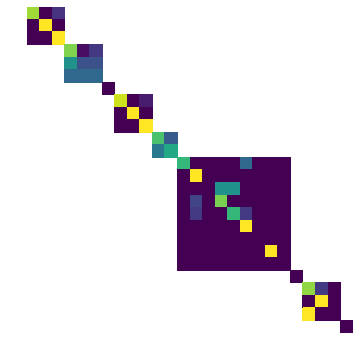

In [22]:
intra_heatmap_matrix = np.zeros((len(set(louvain_combined_dict['go'].cluster_sub)),len(set(louvain_combined_dict['go'].cluster_sub))))
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)
intra_heatmap_matrix

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['ComplementNB']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,6))
ax.axis('off')
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, ax=ax, square=True, cbar=False)

plt.show()

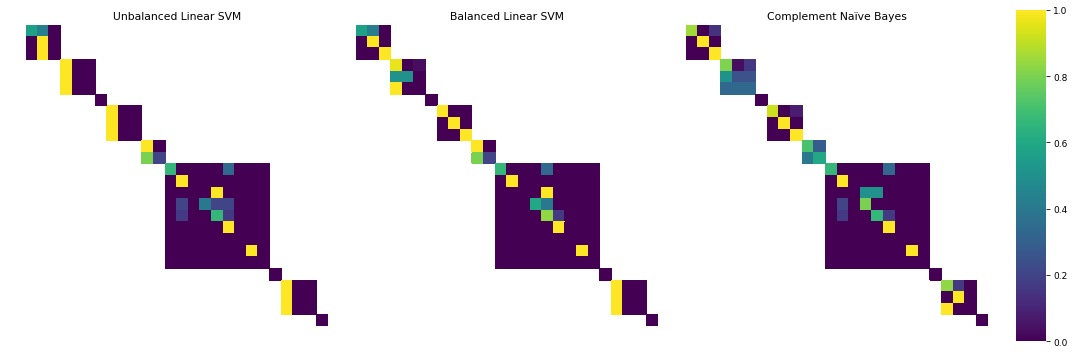

In [191]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(15,5), gridspec_kw={'width_ratios':[10,10,10,1]})
for ax in axes[:3]:
    ax.axis('off')

## put complementNB on the right    
intra_heatmap_matrix = np.zeros((len(set(louvain_combined_dict['go'].cluster_sub)),len(set(louvain_combined_dict['go'].cluster_sub))))
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['ComplementNB']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=True, ax=axes[2], cbar_ax=axes[3])


## put balanced SVC in the middle
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['SVC']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    

sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[1])

### put unbalanced svc on the left
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['unbalSVM']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[0])


## layout and titles
plt.tight_layout()
axes[0].set_title('Unbalanced Linear SVM')
axes[1].set_title('Balanced Linear SVM')
axes[2].set_title('Complement Naïve Bayes')

plt.savefig('../viz/images/intracluster_learnability_comparison.pdf')

plt.show()

### Understudied Test

In [51]:
from scipy.stats import hypergeom
understudied = pd.read_csv('../data/dark_kinases.csv').symbol.tolist()

def test_understudied(clust, understudied, M):
    N = len(clust)
    
    rv = hypergeom(M, len(understudied), N)
    
    k = sum(map(lambda x: x in understudied, clust))
    
    return rv.pmf(k)

In [58]:
understudied_p_vals = []
louv = copy(louvain_combined_dict['go'].drop('GO Labels', axis=1))
louv.head()

,cluster_super,cluster_sub
names,,
MST1R,3,11
YES1,3,11
TYRO3,3,11
FGR,3,11
SRC,3,11


In [59]:
louv['understudied'] = pd.Series(louv.index.to_list()).apply(lambda x: x in understudied).to_list()

In [60]:
understudied_super_p_vals = {}
for i in sorted(louv.cluster_super.unique()):
    understudied_super_p_vals[i]=test_understudied(louv[louv['cluster_super']==i].index.to_list(), understudied, M=len(louv))
    
understudied_sub_p_vals = {}
for i in sorted(louv.cluster_sub.unique()):
    understudied_sub_p_vals[i]=test_understudied(louv[louv['cluster_sub']==i].index.to_list(), understudied, M=len(louv))

In [64]:
sub_super_dict = louv.groupby('cluster_sub')['cluster_super'].agg('mean').to_dict()
sub_super_dict

{1: 4,
 2: 2,
 3: 7,
 4: 6,
 5: 8,
 6: 6,
 7: 1,
 8: 1,
 9: 2,
 10: 6,
 11: 3,
 12: 8,
 13: 5,
 14: 6,
 15: 5,
 16: 4,
 17: 6,
 18: 6,
 19: 4,
 20: 8,
 21: 1,
 22: 6,
 23: 6,
 24: 2,
 25: 6,
 26: 9}

In [65]:
understudied_super_clusts = []
understudied_sub_clusts = []

for clust, p_val in understudied_super_p_vals.items():
    if(p_val < 0.05):
        understudied_super_clusts += [clust]
        
for clust, p_val in understudied_sub_p_vals.items():
    if(p_val < 0.05):
        understudied_sub_clusts += [clust]
        
print(understudied_super_clusts)
print(list(zip(understudied_sub_clusts, [sub_super_dict[x] for x in understudied_sub_clusts])))

[2, 3, 4, 5, 7]
[(1, 4), (2, 2), (3, 7), (7, 1), (11, 3), (13, 5), (19, 4)]


In [66]:
super_under_map = (louv_cluster_df.groupby('cluster_super')['understudied'].agg(sum)/louv_cluster_df.groupby('cluster_super')['understudied'].agg(len)).to_dict()
sub_under_map = (louv_cluster_df.groupby('cluster_sub')['understudied'].agg(sum)/louv_cluster_df.groupby('cluster_sub')['understudied'].agg(len)).to_dict()
louv_cluster_df['super_prop_under'] = louv_cluster_df.cluster_super.apply(super_under_map.get)
louv_cluster_df['super_under_pval'] = louv_cluster_df.cluster_super.apply(understudied_super_p_vals.get)
louv_cluster_df['sub_prop_under'] = louv_cluster_df.cluster_sub.apply(sub_under_map.get)
louv_cluster_df['sub_under_pval'] = louv_cluster_df.cluster_sub.apply(understudied_sub_p_vals.get)

louv_cluster_df.head()

,cluster_super,cluster_sub,understudied,super_prop_under,super_under_pval,sub_prop_under,sub_under_pval
names,,,,,,,
MST1R,3,11,False,0.12,0.000025,0.12,0.000025
YES1,3,11,False,0.12,0.000025,0.12,0.000025
TYRO3,3,11,False,0.12,0.000025,0.12,0.000025
FGR,3,11,False,0.12,0.000025,0.12,0.000025
SRC,3,11,False,0.12,0.000025,0.12,0.000025


In [76]:
agg_dict = {'understudied':len}
agg_dict.update({x:np.mean for x in ['super_prop_under','super_under_pval','sub_prop_under','sub_under_pval']})

understudied_table = louv_cluster_df.groupby(['cluster_super', 'cluster_sub']).agg(agg_dict)
understudied_table['super_prop_under'] = understudied_table['super_prop_under'].apply(lambda x: np.round(x*100,1))
understudied_table['sub_prop_under'] = understudied_table['sub_prop_under'].apply(lambda x: np.round(x*100,1))


raw_columns = ['Subclust\nSize', 'Superclust\n% Understud', 'Superclust \np-value', 'Subclust\n% Understud', 'Subclust \np-value']
multindex_column_tuples = [tuple(col.split('\n')) for col in raw_columns]

understudied_table.columns = pd.MultiIndex.from_tuples(multindex_column_tuples)

for col in understudied_table.columns:
    understudied_table[col] = understudied_table[col].apply(lambda x: np.round(x, 4))
understudied_table


Subclust  Superclust Superclust     Subclust  \
                              Size % Understud     p-value % Understud   
cluster_super cluster_sub                                                
1             7                 17        22.5      0.0697         0.0   
              8                 19        22.5      0.0697        36.8   
              21                 4        22.5      0.0697        50.0   
2             2                123        43.7      0.0001        43.1   
              9                 14        43.7      0.0001        42.9   
              24                 5        43.7      0.0001        60.0   
3             11                75        12.0      0.0000        12.0   
4             1                 52        17.2      0.0056        13.5   
              16                 3        17.2      0.0056         0.0   
              19                 3        17.2      0.0056       100.0   
5             13                31        15.0      0.0091        12.9   
              15                 9        15.0      0.0091        22.2   
6             4                  9        25.0      0.0624        22.2   
              6                  8        25.0      0.0624        12.5   
              10                 3        25.0      0.0624         0.0   
              14                12        25.0      0.0624        33.3   
              17                15        25.0      0.0624        33.3   
              18                 9        25.0      0.0624        44.4   
              22                 2        25.0      0.0624         0.0   
              23                 4        25.0      0.0624         0.0   
              25                 2        25.0      0.0624         0.0   
7             3                 63        14.3      0.0007        14.3   
8             5                 21        28.6      0.1617        19.0   
              12                 5        28.6      0.1617        40.0   
              20                 2        28.6      0.1617       100.0   
9             26                 7        14.3      0.2320        14.3   

                          Subclust   
                            p-value  
cluster_super cluster_sub            
1             7              0.0016  
              8              0.1651  
              21             0.2766  
2             2              0.0005  
              9              0.1390  
              24             0.1429  
3             11             0.0000  
4             1              0.0013  
              16             0.3256  
              19             0.0298  
5             13             0.0109  
              15             0.2574  
6             4              0.2574  
              6              0.1820  
              10             0.3256  
              14             0.2381  
              17             0.2139  
              18             0.1842  
              22             0.4737  
              23             0.2236  
              25             0.4737  
7             3              0.0007  
8             5              0.0976  
              12             0.3181  
              20             0.0966  
9             26             0.2320

In [78]:
understudied_filled_table = copy(understudied_table)
to_keep = np.zeros_like(understudied_filled_table.index.get_level_values(0))

understudied_filled_table = understudied_filled_table[understudied_filled_table.columns[[1,2,0,3,4]]]

for sup_ in understudied_filled_table.index.get_level_values(0):
    local_tab = understudied_filled_table.loc[sup_]
    first_sub = local_tab.index.to_list()[0]
    to_keep = np.logical_or(to_keep, [x == first_sub for x in understudied_filled_table.index.get_level_values(1).to_list()])
    
understudied_filled_table[understudied_filled_table.columns[0]][~to_keep] = ''
understudied_filled_table[understudied_filled_table.columns[1]][~to_keep] = ''

display(understudied_filled_table)
print(understudied_filled_table.to_latex())

Superclust Superclust  Subclust              \
                          % Understud     p-value     Size % Understud   
cluster_super cluster_sub                                                
1             7                  22.5      0.0697       17         0.0   
              8                                         19        36.8   
              21                                         4        50.0   
2             2                  43.7      0.0001      123        43.1   
              9                                         14        42.9   
              24                                         5        60.0   
3             11                   12           0       75        12.0   
4             1                  17.2      0.0056       52        13.5   
              16                                         3         0.0   
              19                                         3       100.0   
5             13                   15      0.0091       31        12.9   
              15                                         9        22.2   
6             4                    25      0.0624        9        22.2   
              6                                          8        12.5   
              10                                         3         0.0   
              14                                        12        33.3   
              17                                        15        33.3   
              18                                         9        44.4   
              22                                         2         0.0   
              23                                         4         0.0   
              25                                         2         0.0   
7             3                  14.3      0.0007       63        14.3   
8             5                  28.6      0.1617       21        19.0   
              12                                         5        40.0   
              20                                         2       100.0   
9             26                 14.3       0.232        7        14.3   

                          Subclust   
                            p-value  
cluster_super cluster_sub            
1             7              0.0016  
              8              0.1651  
              21             0.2766  
2             2              0.0005  
              9              0.1390  
              24             0.1429  
3             11             0.0000  
4             1              0.0013  
              16             0.3256  
              19             0.0298  
5             13             0.0109  
              15             0.2574  
6             4              0.2574  
              6              0.1820  
              10             0.3256  
              14             0.2381  
              17             0.2139  
              18             0.1842  
              22             0.4737  
              23             0.2236  
              25             0.4737  
7             3              0.0007  
8             5              0.0976  
              12             0.3181  
              20             0.0966  
9             26             0.2320

\begin{tabular}{llllrrr}
\toprule
  &    &  Superclust & Superclust  & \multicolumn{2}{l}{Subclust} & Subclust  \\
  &    & \% Understud &     p-value &     Size & \% Understud &   p-value \\
cluster\_super & cluster\_sub &             &             &          &             &           \\
\midrule
1 & 7  &        22.5 &      0.0697 &       17 &         0.0 &    0.0016 \\
  & 8  &             &             &       19 &        36.8 &    0.1651 \\
  & 21 &             &             &        4 &        50.0 &    0.2766 \\
2 & 2  &        43.7 &      0.0001 &      123 &        43.1 &    0.0005 \\
  & 9  &             &             &       14 &        42.9 &    0.1390 \\
  & 24 &             &             &        5 &        60.0 &    0.1429 \\
3 & 11 &          12 &           0 &       75 &        12.0 &    0.0000 \\
4 & 1  &        17.2 &      0.0056 &       52 &        13.5 &    0.0013 \\
  & 16 &             &             &        3 &         0.0 &    0.3256 \\
  & 19 &             &    

### Generate GO Slim whitelist

In [100]:
go_slim_data_dict, go_slim_transform_dict = lh.get_go_data_dict(go_file='../data/goData/kinase_go_slim_processes.csv')

In [101]:
go_slim_data_dict['freq'].iloc[1].shape

(247,)

In [102]:
missing = list(set(go_slim_data_dict['go'].index) - set(go_slim_data_dict['freq'].index))

missing_df = pd.DataFrame([[[0]*len(go_slim_data_dict['freq'].iloc[0])]], index=missing)
go_slim_data_dict['freq'] = go_slim_data_dict['freq'].append(missing_df)
#missing_df

In [103]:
slim_test = pd.DataFrame(go_slim_data_dict['freq'])
slim_test.columns = ['GO Labels']
slim_test['cluster'] = louv.cluster_super.to_list()
slim_test.head()

,GO Labels,cluster
PFKL,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
STK25,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
PIK3R4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
MAP2K1,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
PTK7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",3


In [105]:
louv_X, __, louv_y, __ = lh.get_tts(dat=slim_test,test_size=0)
louv_slim_super_characterizers = [SVC(kernel='linear', class_weight='balanced'), CNB()]
for clf in louv_slim_super_characterizers:
    clf.fit(louv_X, louv_y)
    
slim_feat = list(go_slim_transform_dict['freq'].classes_)#.to_list()
slim_feat

['BMP signaling pathway',
 'DNA damage induced protein phosphorylation',
 'DNA repair',
 'DNA-templated',
 'ERK1 and ERK2 cascade',
 'Fc-epsilon receptor signaling pathway',
 'MAPK cascade',
 'Mullerian duct regression',
 'MyD88-dependent toll-like receptor signaling pathway',
 'MyD88-independent toll-like receptor signaling pathway',
 'Rho protein signal transduction',
 'T cell receptor signaling pathway',
 'Wnt signaling pathway',
 'actin cytoskeleton organization',
 'actin cytoskeleton reorganization',
 'activation of GTPase activity',
 'activation of JUN kinase activity',
 'activin receptor signaling pathway',
 'adherens junction assembly',
 'angiogenesis',
 'animal organ morphogenesis',
 'anterior/posterior pattern specification',
 'apoptotic mitochondrial changes',
 'apoptotic process',
 'apoptotic signaling pathway',
 'attachment of spindle microtubules to kinetochore',
 'axon guidance',
 'blood coagulation',
 'branching involved in blood vessel morphogenesis',
 'branching morph

In [106]:
louv_slim_super_characterizers[0].score(louv_X, louv_y)

0.6479690522243714

### Cluster Comparison

In [125]:
louv_sup = louv['cluster_super']
#spin = spinglass_clusters.set_index('names').drop('GO Labels', axis=1)
fast = pd.read_csv(cluster_dir+fastgreedy_file, sep='\t',index_col=0)['cluster']

Below is the fast_greedy membership of each c_spinglass cluster

In [128]:
cont_mat

,0,1,2,3,4,5,6,7,8
0,0.025000,0.850000,0.000000,0.041667,0.075000,0.008333,0.000000,0.000000,0.0
1,0.009615,0.019231,0.432692,0.326923,0.173077,0.009615,0.028846,0.000000,0.0
2,0.164706,0.070588,0.023529,0.082353,0.023529,0.000000,0.623529,0.011765,0.0
3,0.031746,0.198413,0.182540,0.063492,0.063492,0.404762,0.015873,0.039683,0.0
4,0.031250,0.156250,0.000000,0.000000,0.000000,0.000000,0.125000,0.687500,0.0
5,0.653846,0.038462,0.192308,0.000000,0.076923,0.000000,0.038462,0.000000,0.0
6,0.000000,0.090909,0.000000,0.000000,0.090909,0.818182,0.000000,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
9,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [141]:
cont_mat_rev.values != 0

array([[ True,  True, False,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True, False,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True, False, False, False, False,  True,  True, False],
       [ True,  True,  True, False,  True, False,  True, False, False],
       [False,  True, False, False,  True,  True, False, False, False],
       [False, False, False, False, False, False, False, False,  True],
       [False, False, False, False, False,  True, False, False, False],
       [False, False, False,  True, False, False, False, False, False]])

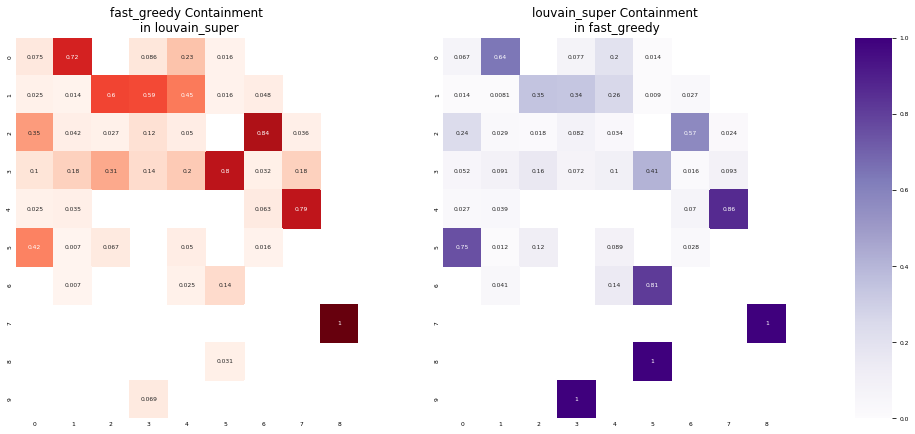

In [156]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

fig, axes = plt.subplots(ncols=3, figsize=(16,7), sharey=False, gridspec_kw={'width_ratios':[10,10,1]})

# fast_greedy membership of louv
cont_mat = pd.DataFrame(contingency_matrix(fast, louv_sup))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=0),axis = 1)
cont_mat_mask = cont_mat.values == 0

axes[0].set_title('fast_greedy Containment\n in louvain_super', size=12)
axes[0].tick_params(axis='both', length=0)
sns.heatmap(cont_mat, ax=axes[0], cmap='Reds', cbar=False, square=True, annot=True, mask=cont_mat_mask)

# louv membership of fast_greedy
cont_mat_rev = pd.DataFrame(contingency_matrix(fast, louv_sup))
cont_mat_rev = cont_mat.divide(other = cont_mat.sum(axis=1),axis = 0)
cont_mat_rev_mask = cont_mat_rev.values == 0

axes[1].set_title('louvain_super Containment\n in fast_greedy', size=12)
axes[1].tick_params(axis='both', length=0)
sns.heatmap(cont_mat_rev, ax=axes[1], cmap='Purples', cbar_ax=axes[2], square=True, annot=True, mask=cont_mat_rev_mask)

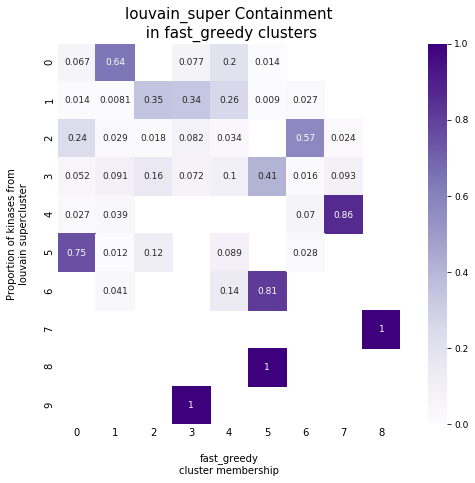

In [190]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))

plt.rc('font', **{'family':'normal', 'size':9})    
ax.set_title('louvain_super Containment\n in fast_greedy clusters', size=15)
ax.tick_params(axis='both', length=0)

sns.heatmap(cont_mat_rev, ax=ax, cmap='Purples',square=True, annot=True, mask=cont_mat_rev_mask)
plt.xlabel('\nfast_greedy\ncluster membership')
plt.ylabel('Proportion of kinases from\nlouvain supercluster\n')

plt.savefig('../viz/images/randomized_louvain_in_fast_greedy.pdf')
plt.show()

Below is the louvain membership of each fast_greedy cluster

Rand correlation matrix

In [114]:
clusts = {}
for method in method_list:
    cl = composite_data_dict[method]['go']
    clusts[method] = np.squeeze(cl.drop(['GO Labels'], axis=1).values)

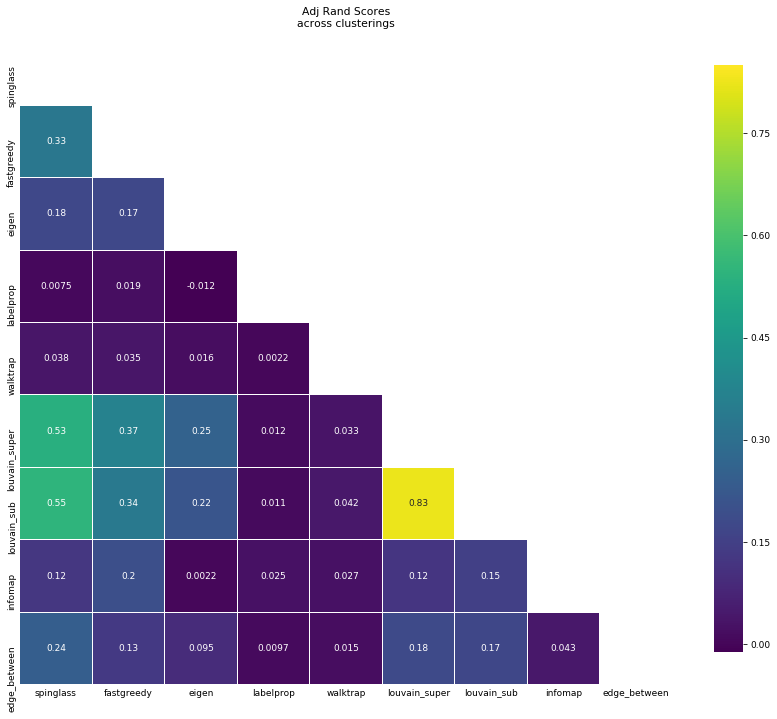

In [186]:
from sklearn.metrics import adjusted_rand_score as rand
rand_corr_matrix = np.zeros((len(clusts), len(clusts)))

fig, ax = plt.subplots(figsize=(15,12))

for i in range(len(clusts)):
    for j in range(len(clusts)):
        rand_corr_matrix[i,j] = rand(clusts[method_list[i]], clusts[method_list[j]])

mask = np.zeros_like(rand_corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
        
ax.tick_params(axis='both', length=0)
ax.set_title('Randomized\nAdj Rand Scores\nacross clusterings')
sns.heatmap(rand_corr_matrix,mask=mask,cmap='viridis', square=True, vmax=.85, cbar_kws={"shrink": .9}, linewidths=0.01, xticklabels=method_list,yticklabels=method_list, ax = ax, annot=True)

plt.savefig('../viz/images/randomized_adj_rand_scores.pdf')
plt.show()